In [21]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
import tensorflow.contrib.metrics as metrics
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.rnn as rnn


In [22]:
tf.__version__

'1.10.0'

In [24]:
import os
cwd = os.getcwd()
print(cwd)
invoice_df = pd.read_excel(cwd+"/Sample_data.xls")
invoice_df.head(5)

/Users/suvarnasundarakrishnan/research


,LOCATION,DATE,Datacount,dayofweek,party,lastwkavg,wk1wk2,wk1wk3
0,X31,2012-07-02,126,2,0,103.666667,0.968847,1.040134
1,X31,2012-07-03,103,3,0,103.666667,0.968847,1.040134
2,X31,2012-07-05,118,5,0,103.666667,0.968847,1.040134
3,X31,2012-07-06,111,6,0,103.666667,0.968847,1.040134
4,X31,2012-07-07,114,7,0,103.666667,0.968847,1.040134


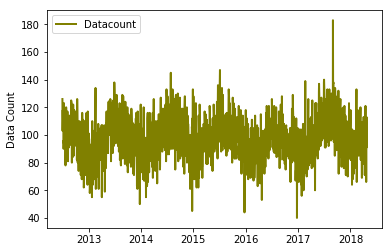

In [32]:
subset_df = invoice_df.loc[invoice_df['LOCATION'] == 'X31']
start_date = '20120702'
end_date = '20171231'
final_df= subset_df[['DATE','Datacount']]
dayofweekdf = subset_df[['dayofweek','Datacount']]
timeseriesdata = final_df[['Datacount']]

#timeseriesdata = final_df[(final_df['CSLDATE'] >= start_date) & (final_df['CSLDATE'] <= end_date)]
#timeseriesdata.plot(c='b',title = 'Invoice Time Series Data')
#plt.show()

timeseriesdata.tail(20)
plt.figure()
plt.plot('DATE','Datacount', data = final_df, marker='', color='olive', linewidth=2)
plt.legend()
#plt.xlabel('Date')
plt.ylabel('Data Count')
plt.show()

In [33]:
TS = np.array(dayofweekdf)
num_periods = 30
f_horizon = 1
#x_data  = TS[:(len(TS)-(len(TS) % num_periods))]
x_data  = TS[:30]
x_batches = x_data.reshape(-1,30,2)
#y_data = TS[1:(len(TS)-(len(TS) % num_periods))+f_horizon]
y_data = TS[1:31]
y_batches = y_data.reshape(-1,30,2)
print (len(x_batches))
print (x_batches.shape)
print (x_batches[0:2])

print(y_batches[0:1])
print(y_batches.shape)

print(len(TS))

1
(1, 30, 2)
[[[  2 126]
  [  3 103]
  [  5 118]
  [  6 111]
  [  7 114]
  [  2 114]
  [  3  90]
  [  4  96]
  [  5  94]
  [  6 123]
  [  7 103]
  [  2 109]
  [  3 107]
  [  4  99]
  [  5  94]
  [  6  93]
  [  7 119]
  [  2  78]
  [  3  78]
  [  4  92]
  [  5  94]
  [  6  94]
  [  7 120]
  [  2  97]
  [  3 104]
  [  4  90]
  [  5  86]
  [  6 105]
  [  7  99]
  [  2 117]]]
[[[  3 103]
  [  5 118]
  [  6 111]
  [  7 114]
  [  2 114]
  [  3  90]
  [  4  96]
  [  5  94]
  [  6 123]
  [  7 103]
  [  2 109]
  [  3 107]
  [  4  99]
  [  5  94]
  [  6  93]
  [  7 119]
  [  2  78]
  [  3  78]
  [  4  92]
  [  5  94]
  [  6  94]
  [  7 120]
  [  2  97]
  [  3 104]
  [  4  90]
  [  5  86]
  [  6 105]
  [  7  99]
  [  2 117]
  [  3 102]]]
(1, 30, 2)
1788


In [34]:
def test_data(series,forecast,num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1,30,2)
    testY = TS[-(num_periods):].reshape(-1,30,1)
    print(testX.shape)
    print(testY.shape)
    return testX,testY
X_test,Y_test = test_data(TS,f_horizon,num_periods)
print (X_test.shape)
print (X_test)
print (Y_test.shape)

(1, 30, 2)
(2, 30, 1)
(1, 30, 2)
[[[  4  78]
  [  5  69]
  [  6  93]
  [  7 109]
  [  2  95]
  [  3 103]
  [  4  88]
  [  5  79]
  [  6  87]
  [  7 101]
  [  2  91]
  [  3 113]
  [  4  89]
  [  5  89]
  [  6  79]
  [  7  89]
  [  2 100]
  [  3  78]
  [  4  71]
  [  5  82]
  [  6  94]
  [  7  96]
  [  2 121]
  [  3 101]
  [  4  79]
  [  5 106]
  [  6  88]
  [  7  66]
  [  2 113]
  [  3  91]]]
(2, 30, 1)


In [35]:

tf.reset_default_graph()
num_periods = 30
inputs =2
hidden =100
output = 2
X=tf.placeholder(tf.float32, [1,num_periods,inputs])
Y=tf.placeholder(tf.float32, [1, num_periods, output])

#x = tf.placeholder(tf.float32, shape=[None, 2])
#y_ = tf.placeholder(tf.float32, shape=[None, 2])
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation = tf.nn.relu)
rnn_output,states = tf.nn.dynamic_rnn(basic_cell,X,dtype=tf.float32)

learning_rate = 0.0001
stacked_rnn_output = tf.reshape(rnn_output,[-1,hidden])
stacked_outputs = tf.layers.dense(stacked_rnn_output,output)
outputs = tf.reshape(stacked_outputs, [-1,num_periods,output])

loss = tf.reduce_sum(tf.square(outputs-Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
init = tf.global_variables_initializer()
print(X)
print(Y)

Tensor("Placeholder:0", shape=(1, 30, 2), dtype=float32)
Tensor("Placeholder_1:0", shape=(1, 30, 2), dtype=float32)


In [36]:
epochs = 10000
with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict = {X:x_batches,Y: y_batches})
        if ep%100 ==0:
                mse = loss.eval(feed_dict={X:x_batches,Y:y_batches})
                print(ep, "\MSE:",mse)
    y_pred = sess.run(outputs,feed_dict={X: X_test})
    print(y_pred)

0 \MSE: 400267.94
100 \MSE: 59076.5
200 \MSE: 22986.58
300 \MSE: 18205.947
400 \MSE: 15089.27
500 \MSE: 12745.226
600 \MSE: 10943.627
700 \MSE: 9238.683
800 \MSE: 7698.0195
900 \MSE: 6344.08
1000 \MSE: 5348.507
1100 \MSE: 4360.587
1200 \MSE: 3572.5051
1300 \MSE: 2991.2937
1400 \MSE: 2508.764
1500 \MSE: 2092.008
1600 \MSE: 1721.3451
1700 \MSE: 1393.4194
1800 \MSE: 1108.4402
1900 \MSE: 864.8356
2000 \MSE: 659.93304
2100 \MSE: 492.23877
2200 \MSE: 358.36514
2300 \MSE: 254.59499
2400 \MSE: 176.12402
2500 \MSE: 118.386444
2600 \MSE: 77.23378
2700 \MSE: 48.835907
2800 \MSE: 29.902876
2900 \MSE: 17.715496
3000 \MSE: 10.136969
3100 \MSE: 5.6009846
3200 \MSE: 2.985587
3300 \MSE: 1.5345612
3400 \MSE: 0.76036876
3500 \MSE: 0.36294147
3600 \MSE: 0.16705061
3700 \MSE: 0.074217096
3800 \MSE: 0.03190166
3900 \MSE: 0.013310056
4000 \MSE: 0.0054486077
4100 \MSE: 0.002197936
4200 \MSE: 0.0009055554
4300 \MSE: 0.0003976748
4400 \MSE: 0.00019566165
4500 \MSE: 7.107896e-05
4600 \MSE: 0.0046579037
4700 \MSE

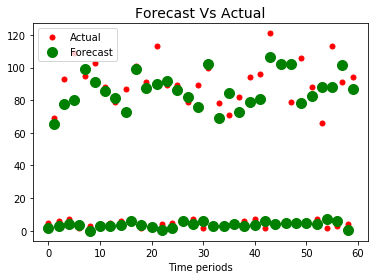

In [54]:
plt.title("Forecast Vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)),"r.",markersize = 10, label = "Actual")
#plt.plot(pd.Series(np.ravel(Y_test)),"w*",markersize = 10)

plt.plot(pd.Series(np.ravel(y_pred)),"go",markersize = 10, label = "Forecast")
plt.legend(loc= "upper left")
plt.xlabel("Time periods")
plt.show()
#Green is forecasted and Red is Actual Data . 

In [42]:
fcst=pd.Series(np.ravel(y_pred))
act=pd.Series(np.ravel(Y_test))

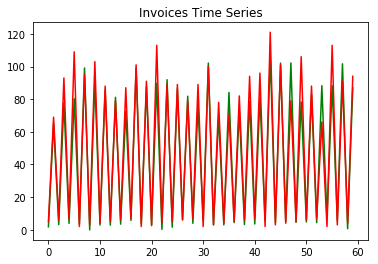

In [43]:

fcst.plot(c='g',title = 'Invoices Time Series')
act.plot(c='r')

plt.show()
sess.close()
#Green displays forecasted data and Red is actual data . 